# Functions

### Tokenizing Functions

In [ ]:
!pip install gensim

In [ ]:
import pandas as pd
from collections import Counter
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel
import torch


In [ ]:
def k_mers(sequences, k=3):
    results = []
    for seq in sequences:
        kmers = [seq[i:i+k] for i in range(0, len(seq), k)]
        results.append(kmers)
    return pd.DataFrame({"sequence": sequences, "k_mers": results})


def sliding_k_mers(sequences, k=3):
    results = []
    for seq in sequences:
        kmers = [seq[i:i+k] for i in range(len(seq)-k+1)] if len(seq) >= k else []
        results.append(kmers)
    return pd.DataFrame({"sequence": sequences, "sliding_k_mers": results})


def simple_bpe(sequences, num_merges=2):
    results = []
    for seq in sequences:
        tokens = list(seq)
        for _ in range(num_merges):
            pairs = [tokens[i]+tokens[i+1] for i in range(len(tokens)-1)]
            if not pairs:
                break
            most_common = Counter(pairs).most_common(1)[0][0]
            i = 0
            new_tokens = []
            while i < len(tokens):
                if i < len(tokens)-1 and tokens[i]+tokens[i+1] == most_common:
                    new_tokens.append(tokens[i]+tokens[i+1])
                    i += 2
                else:
                    new_tokens.append(tokens[i])
                    i += 1
            tokens = new_tokens
        results.append(tokens)
    return pd.DataFrame({"sequence": sequences, "bpe_tokens": results})


def naive(sequences):
    results = [list(seq) for seq in sequences]
    return pd.DataFrame({"sequence": sequences, "naive_tokens": results})


### Embedding Functions

In [ ]:
def one_hot(sequences):
    results = []
    for seq in sequences:
        tokens = list(seq)
        vocab = sorted(set(tokens))
        token_to_idx = {token: i for i, token in enumerate(vocab)}
        one_hot_matrix = np.eye(len(vocab))[[token_to_idx[t] for t in tokens]]
        results.append(one_hot_matrix)
    return pd.DataFrame({"sequence": sequences, "one_hot": results})


def positional_encoding(sequences, d_model):
    results = []
    for seq in sequences:
        seq_len = len(seq)
        pos = np.arange(seq_len)[:, np.newaxis]
        i = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / d_model)
        pe = pos * angle_rates
        pe[:, 0::2] = np.sin(pe[:, 0::2])
        pe[:, 1::2] = np.cos(pe[:, 1::2])
        results.append(pe)
    return pd.DataFrame({"sequence": sequences, "positional_encoding": results})


def word2vec_embeddings(sequences, k):
    results = []
    for seq in sequences:
        kmers = [seq[i:i+k] for i in range(0, len(seq)-k+1)]
        sentences = [kmers]
        w2v_model = Word2Vec(sentences, vector_size=8, window=2, min_count=1, sg=1)
        w2v_emb = np.array([w2v_model.wv[k] for k in kmers])
        results.append(w2v_emb)
    return pd.DataFrame({"sequence": sequences, "word2vec": results})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dna_tokenizer = BertTokenizer.from_pretrained("zhihan1996/DNA_bert_6")
dna_model = BertModel.from_pretrained("zhihan1996/DNA_bert_6").to(device)

nt_model_name = "InstaDeepAI/nucleotide-transformer-2.5b-multi-species"
nt_tokenizer = AutoTokenizer.from_pretrained(nt_model_name)
nt_model = AutoModel.from_pretrained(nt_model_name).to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at InstaDeepAI/nucleotide-transformer-2.5b-multi-species and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def dna_bert(sequences, batch_size=16):
    results = []
    sequences=list(sequences)
    for i in range(0, len(sequences), batch_size):
        batch = sequences[i:i + batch_size]
        #print(batch)
        inputs = dna_tokenizer(batch, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = dna_model(**inputs)
        # outputs.last_hidden_state: (batch_size, seq_len, hidden_size)
        batch_emb = [emb.squeeze(0).cpu().numpy() for emb in outputs.last_hidden_state]
        results.extend(batch_emb)
    return pd.DataFrame({"sequence": sequences, "dna_bert": results})


def nt(sequences, batch_size=8):
    results = []
    sequences=list(sequences)
    for i in range(0, len(sequences), batch_size):
        batch = sequences[i:i + batch_size]
        inputs = nt_tokenizer(batch, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = nt_model(**inputs)
        batch_emb = [emb.squeeze(0).cpu().numpy() for emb in outputs.last_hidden_state]
        results.extend(batch_emb)
    return pd.DataFrame({"sequence": sequences, "nt_embedding": results})

# Visualize Tokens

Load the DNA dataset and look at the data

In [ ]:
dataset=pd.read_csv('/content/synthetic_dna_dataset.csv')
sequences=dataset['Sequence']
print(sequences.head(5))
print()
print('Length: ', len(sequences[0]))

0    CTTTCGGGATACTTTTGGGATGGTCTTGGTCAAGGGTTTTAGCCCG...
1    TTGACCAAATTTGATTGGAAGTGGTAAGCGCGTATTCCTAGCATCA...
2    GCGTGAGTTCTAATTTAAAAAGTCGTAACACGTACCCCGGCGTGTA...
3    ACTACGCGGACAAGAACCAACAGAACCTGGTTTTCGCAAGGGAGTG...
4    TTCAATGCAGATTGAAAGTTACTTTCATCTGCCCTATGGGTCCCTT...
Name: Sequence, dtype: object

Length:  100


Generate the 5 types of tokens and print the tokens for the first sequence

In [ ]:
kmer_tokens3=k_mers(sequences,k=3)
kmer_tokens4=k_mers(sequences,k=4)
sliding_kmer_tokens=sliding_k_mers(sequences)
bpe_tokens=simple_bpe(sequences)
naive_tokens=naive(sequences)
print(sequences[0])
print('==============================================================================================================')
print('3-mer Tokens:         ',kmer_tokens3['k_mers'][0])
print('4-mer Tokens:         ',kmer_tokens4['k_mers'][0])
print('Sliding 3-mer Tokens: ',sliding_kmer_tokens['sliding_k_mers'][0])
print('BPE Tokens:           ',bpe_tokens['bpe_tokens'][0])
print('Naive Tokens:         ',naive_tokens['naive_tokens'][0])

CTTTCGGGATACTTTTGGGATGGTCTTGGTCAAGGGTTTTAGCCCGCAGACAGACTTTAAAACGAACCTTGCGGCAATTGCGGGCGAGAAGTTGGCTTAG
3-mer Tokens:          ['CTT', 'TCG', 'GGA', 'TAC', 'TTT', 'TGG', 'GAT', 'GGT', 'CTT', 'GGT', 'CAA', 'GGG', 'TTT', 'TAG', 'CCC', 'GCA', 'GAC', 'AGA', 'CTT', 'TAA', 'AAC', 'GAA', 'CCT', 'TGC', 'GGC', 'AAT', 'TGC', 'GGG', 'CGA', 'GAA', 'GTT', 'GGC', 'TTA', 'G']
4-mer Tokens:          ['CTTT', 'CGGG', 'ATAC', 'TTTT', 'GGGA', 'TGGT', 'CTTG', 'GTCA', 'AGGG', 'TTTT', 'AGCC', 'CGCA', 'GACA', 'GACT', 'TTAA', 'AACG', 'AACC', 'TTGC', 'GGCA', 'ATTG', 'CGGG', 'CGAG', 'AAGT', 'TGGC', 'TTAG']
Sliding 3-mer Tokens:  ['CTT', 'TTT', 'TTC', 'TCG', 'CGG', 'GGG', 'GGA', 'GAT', 'ATA', 'TAC', 'ACT', 'CTT', 'TTT', 'TTT', 'TTG', 'TGG', 'GGG', 'GGA', 'GAT', 'ATG', 'TGG', 'GGT', 'GTC', 'TCT', 'CTT', 'TTG', 'TGG', 'GGT', 'GTC', 'TCA', 'CAA', 'AAG', 'AGG', 'GGG', 'GGT', 'GTT', 'TTT', 'TTT', 'TTA', 'TAG', 'AGC', 'GCC', 'CCC', 'CCG', 'CGC', 'GCA', 'CAG', 'AGA', 'GAC', 'ACA', 'CAG', 'AGA', 'GAC', 'ACT', 'CTT', 'TTT',

# Visualize Embeddings

Generate Embeddings for 50 sequences

In [ ]:
sequences_10=sequences[:50]
one_hot_emb=one_hot(sequences_10)
pos_emb=positional_encoding(sequences_10,d_model=8)
w2v_emb=word2vec_embeddings(sequences_10,k=3)
dna_bert_emb=dna_bert(sequences_10)
nt_emb=nt(sequences_10)



Visualize Embeddings

/tmp/ipython-input-3197305571.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(seqs)
/tmp/ipython-input-3197305571.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(seqs)
/tmp/ipython-input-3197305571.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(seqs)
/tmp/ipython-input-3197305571.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(seqs)
/tmp/ipython-input-3197305571.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(seqs)


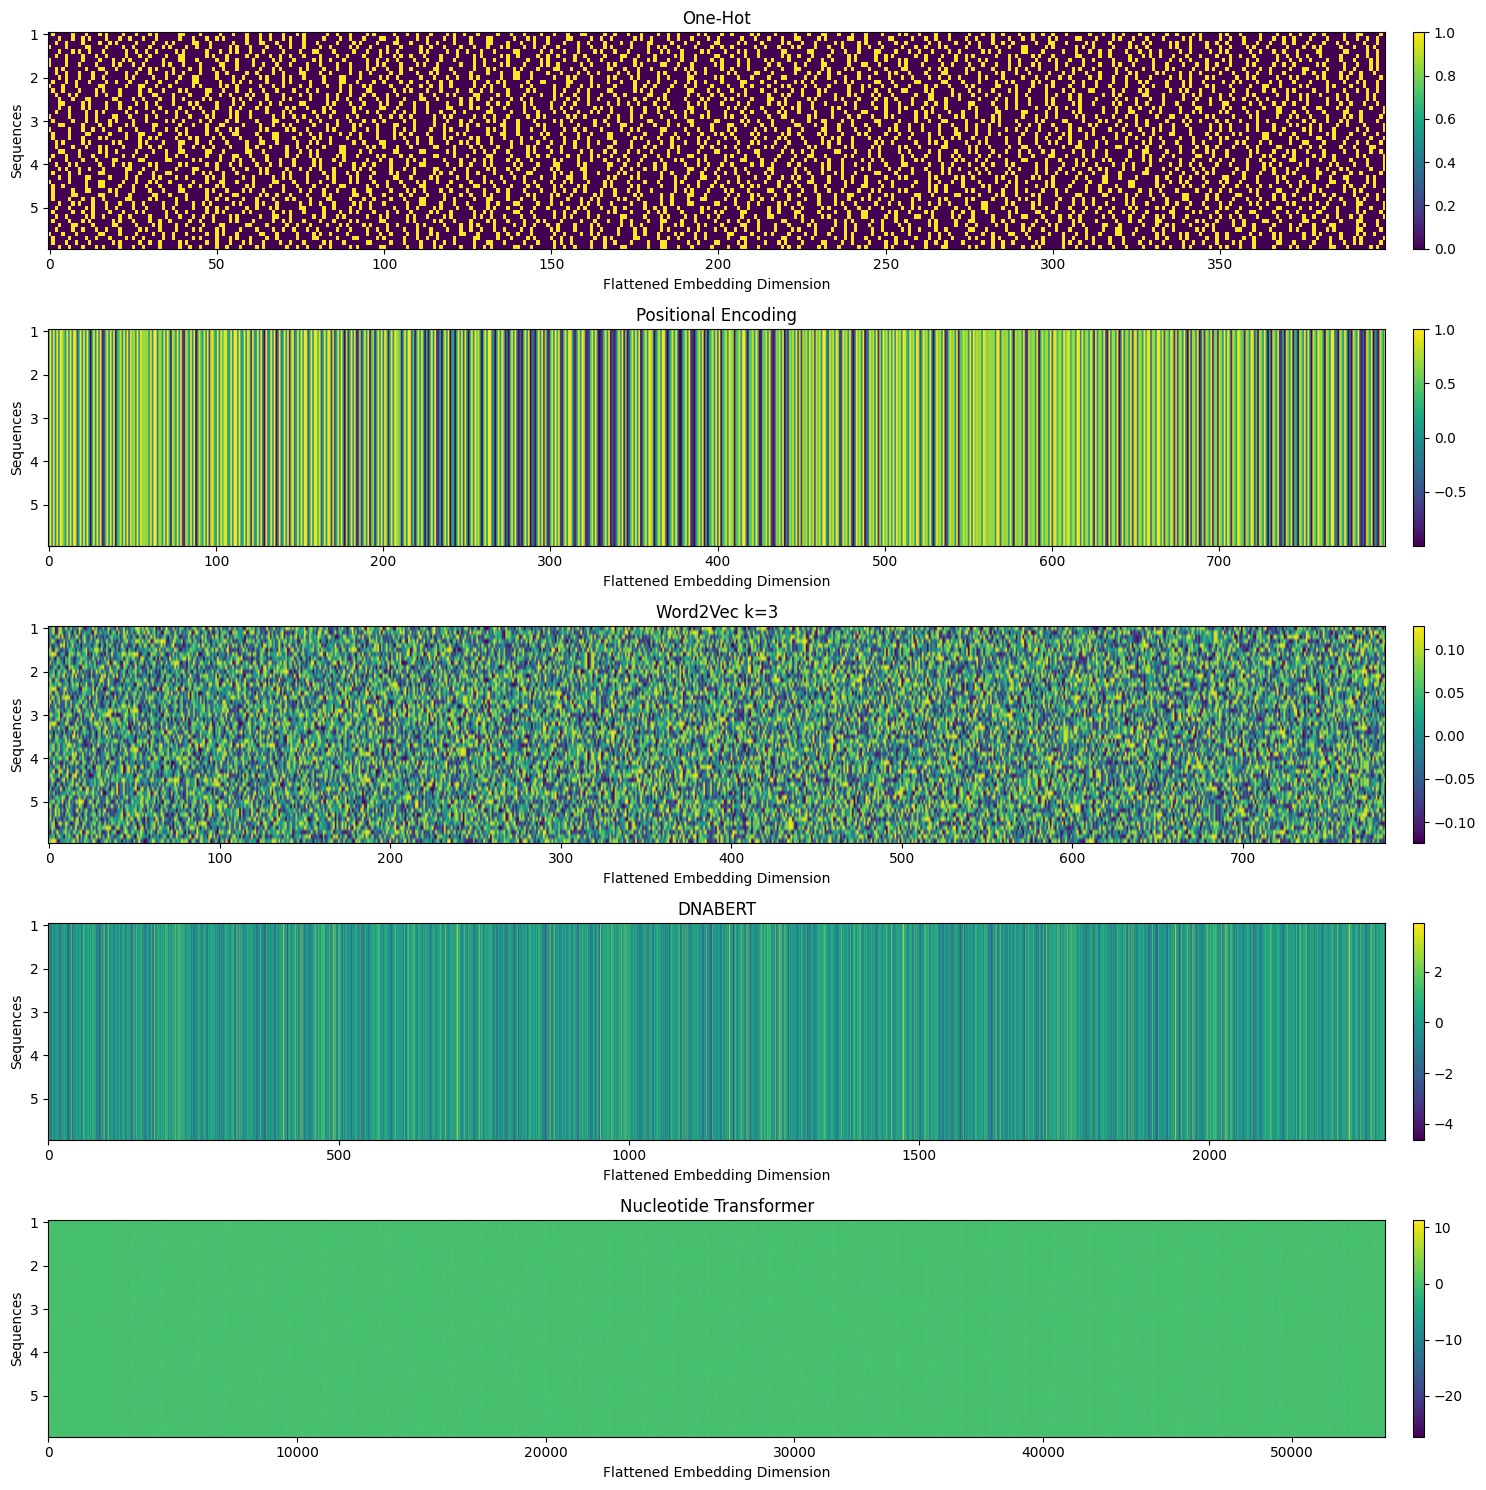

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten embeddings helper
def flatten_embeddings(df, col_name):
    return np.array([emb.flatten() for emb in df[col_name]])

# Prepare flattened embeddings
embeddings_dict = {
    "One-Hot": flatten_embeddings(one_hot_emb, "one_hot"),
    "Positional Encoding": flatten_embeddings(pos_emb, "positional_encoding"),
    "Word2Vec k=3": flatten_embeddings(w2v_emb, "word2vec"),
    "DNABERT": flatten_embeddings(dna_bert_emb, "dna_bert"),
    "Nucleotide Transformer": flatten_embeddings(nt_emb, "nt_embedding")
}

# Generate sequence labels as Seq1, Seq2, ...
seqs = [i for i in range(len(one_hot_emb))]

# Plot heatmaps
fig, axes = plt.subplots(len(embeddings_dict), 1, figsize=(15, 3*len(embeddings_dict)))

for ax, (title, emb) in zip(axes, embeddings_dict.items()):
    im = ax.imshow(emb, aspect='auto', cmap='viridis')
    ax.set_title(title)
    ax.set_ylabel("Sequences")
    ax.set_yticklabels(seqs)
    ax.set_xlabel("Flattened Embedding Dimension")
    fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.02)

plt.tight_layout()
plt.show()
